# Neural Networks

Imports and Helper Functions
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from subprocess import call
import ipywidgets as widgets
from IPython.display import display
from sklearn import datasets as skdatasets
from ipywidgets import interactive_output

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

## Model Creation

In [3]:
#Define a basic MLP with pyTorch
class MLP(nn.Module):
    def __init__(self, K):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, K)
        self.out = nn.Linear(K, 1)
        self.ceriation = nn.BCELoss()

    def _predict_proba(self, X):
        h1 = torch.sigmoid(self.fc1(X))
        yhat = torch.sigmoid(self.out(h1))
        return yhat

    def forward(self, X, y):
        yhat = self._predict_proba(X)
        loss = self.ceriation(yhat, y)
        return loss

    def predict_proba(self, X):
        X = Variable(torch.from_numpy(X).float())
        yhat = self._predict_proba(X)
        return yhat.data.numpy()

    def fit(self, X, y, verbose=False):
        X2 = torch.from_numpy(X).float()
        y2 = torch.from_numpy(y[:, np.newaxis]).float()
        optimizer = optim.Adam(self.parameters(), lr=0.1, weight_decay=1e-4)

        old_loss = np.inf
        for epoch in range(100):
            optimizer.zero_grad()
            loss = self(Variable(X2), Variable(y2))
            loss.backward()
            optimizer.step()
            if np.abs(loss.data.item() - old_loss) / np.abs(loss.data.item()) < 1e-6:
                break
            old_loss = loss.data.item()
            if verbose:
                print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data.item()))
        if verbose:
            print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data.item()))

## Dataset Generation

In [4]:
N = 100
datasets = {}

X = np.vstack((2.5 * np.random.randn(int(N / 2), 2) - 5, (2.5 * np.random.randn(int(N / 2), 2) + 5)))
y = np.hstack((-1 * np.ones((int(N / 2))), np.ones((int(N / 2)))))
ind = np.random.permutation(range(N))
datasets["Dataset 1"] = (X[ind, :], y[ind])

In [5]:
iris = skdatasets.load_iris()
X = iris.data[:, :2][:100]  # we only take the first two features. First 100 examples have only 2 classes.
y = iris.target[:100]
y[(y == 0)] = -1  # convert 0 class label to -1.
ind = np.random.permutation(range(100))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

# Rescale the data to [-9, 9] range.
old_min, old_max = np.min(X[:, 0]), np.max(X[:, 0])
old_range = old_max - old_min
X[:, 0] = (X[:, 0] - old_min) * 18 / old_range + (-9)

old_min, old_max = np.min(X[:, 1]), np.max(X[:, 1])
old_range = old_max - old_min
X[:, 1] = (X[:, 1] - old_min) * 18 / old_range + (-9)

datasets["Dataset 2"] = X, y

In [6]:
X, y = skdatasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=None)
y[(y == 0)] = -1

# Rescale the data to [-9, 9] range.
old_min, old_max = np.min(X[:, 0]), np.max(X[:, 0])
old_range = old_max - old_min
X[:, 0] = (X[:, 0] - old_min) * 18 / old_range + (-9)

old_min, old_max = np.min(X[:, 1]), np.max(X[:, 1])
old_range = old_max - old_min
X[:, 1] = (X[:, 1] - old_min) * 18 / old_range + (-9)

datasets["Dataset 3"] = X, y

In [7]:
# generate points for the four quadrants
n_4 = int(N / 4)
x1 = np.random.normal(loc=[5, 5], scale=2, size=(n_4, 2))
x2 = np.random.normal(loc=[-5, 5], scale=2, size=(n_4, 2))
x3 = np.random.normal(loc=[-5, -5], scale=2, size=(n_4, 2))
x4 = np.random.normal(loc=[5, -5], scale=2, size=(n_4, 2))

# make quadrant 1 and 3 as -1 label, 2 and 4 as +1 label.
X = np.vstack((x1, x3, x2, x4))
y = np.hstack((-1 * np.ones(n_4 * 2), np.ones(n_4 * 2)))

ind = np.random.permutation(range(N))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

datasets["Dataset 4"] = X, y

In [8]:
# Generate 4 separate lines data
n_4 = int(N / 4)

x10 = np.random.uniform(-9.5, -5, n_4)
x11 = x10 + 13 + np.random.uniform(0, 2, n_4)
x1 = np.squeeze(np.dstack((x10, x11)))

x30 = np.random.uniform(0, 8.5, n_4)
x31 = x30 - 5 + np.random.uniform(0, 2, n_4)
x3 = np.squeeze(np.dstack((x30, x31)))

x20 = np.random.uniform(-9.5, -1, n_4)
x21 = x20 + 5 + np.random.uniform(0, 2, n_4)
x2 = np.squeeze(np.dstack((x20, x21)))

x40 = np.random.uniform(5, 9.5, n_4)
x41 = x40 - 13 - np.random.uniform(0, 2, n_4)
x4 = np.squeeze(np.dstack((x40, x41)))

X = np.vstack((x1, x3, x2, x4))
y = np.hstack((-1 * np.ones(n_4 * 2), np.ones(n_4 * 2)))

ind = np.random.permutation(range(N))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

datasets["Dataset 5"] = X, y

In [9]:
X, y = skdatasets.make_circles(n_samples=N, shuffle=True, noise=0.08, random_state=None, factor=0.4)
y[(y == 0)] = -1

# Rescale the data to [-9, 9] range.
X[:, 0] = (X[:, 0] + 1) * 18 / 2 + (-9)
X[:, 1] = (X[:, 1] + 1) * 18 / 2 + (-9)

datasets["Dataset 6"] = X, y

In [10]:
X, y = skdatasets.make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=2, flip_y=0.05,
                                     scale=[5, 5], class_sep=0.5)
y[(y == 0)] = -1
# print(X, y)
datasets["Dataset 7"] = X, y

## Plotting Function

In [11]:
def plot_nn_classifier(dataset='Dataset 1', N=10, K=5):
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 12})

    if dataset is not None and N > 0:
        # Gather dataset

        X, Y = datasets[dataset]
        X = X[:N]
        Y = Y[:N]
        Y[Y == -1] = 0  # change Y labels to be sigmoid compatible

        # Plot original data

        ind1 = (Y == 1)
        indm1 = (Y == 0)
        plt.plot(X[ind1, 0], X[ind1, 1], 'bs', alpha=0.5)
        plt.plot(X[indm1, 0], X[indm1, 1], 'rs', alpha=0.5)

        # Create the classifier

        model = MLP(K)
        model.fit(X, Y)

        # Calculate prediction error

        Yprob = np.reshape(model.predict_proba(X), -1)
        Yhat = 1 * (Yprob >= 0.5)
        R = np.mean(Yhat != Y)

        # Create contours for background plot

        gx1, gx2 = np.meshgrid(np.arange(-10, 10, 1 / 10.0), np.arange(-10, 10, 1 / 10.0))
        gx1l = gx1.flatten()
        gx2l = gx2.flatten()
        gx = np.vstack((gx1l, gx2l)).T
        gyhat = 2*(model.predict_proba(gx)[:, 0]-0.5)
        gyhat = gyhat.reshape(gx1.shape)
        #         print('gyhat={}'.format(gyhat))

        if (not all(gyhat.flatten() == 0)):
            contours = plt.contour(gx1, gx2, gyhat, levels=[0], linewidths=2, colors=["k"])
            plt.imshow(gyhat, interpolation='nearest', extent=(-10, 10, -10, 10), aspect='auto', origin='lower',
                       cmap=plt.cm.bwr_r, alpha=0.50)
            plt.clim(-1, 1)
            plt.colorbar()

        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.title("MLP classifier. Error rate: {:.4g}".format(R))
        plt.xlabel("X0")
        plt.ylabel("X1")
        plt.grid(True)
        plt.legend(["Class 1", "Class -1"], loc='upper left')
        plt.show()

In [12]:
# Test cell
# plot_nn_classifier(dataset="Dataset 5", N=100, K=5)

In [17]:
wd = widgets.Dropdown(
    options=["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4", "Dataset 5", "Dataset 6", "Dataset 7"],
    description="Dataset"
)
wn = widgets.IntSlider(value=10, min=1, max=N, step=1, description="N", continuous_update=False)
wk = widgets.IntSlider(
    value=1,
    min=1,
    max=50,
    step=1,
    description='K:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

out = interactive_output(
    plot_nn_classifier,
    {
        "dataset": wd,
        "N": wn,
        "K": wk,
    }
)

#out.layout.height = '400px'
box1 = widgets.HBox([wd, wn, wk])
ui = widgets.VBox([box1]);

In [18]:
display(ui)
display(out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1000x600 with 2 Axes>', '…

### Types of Hidden Units

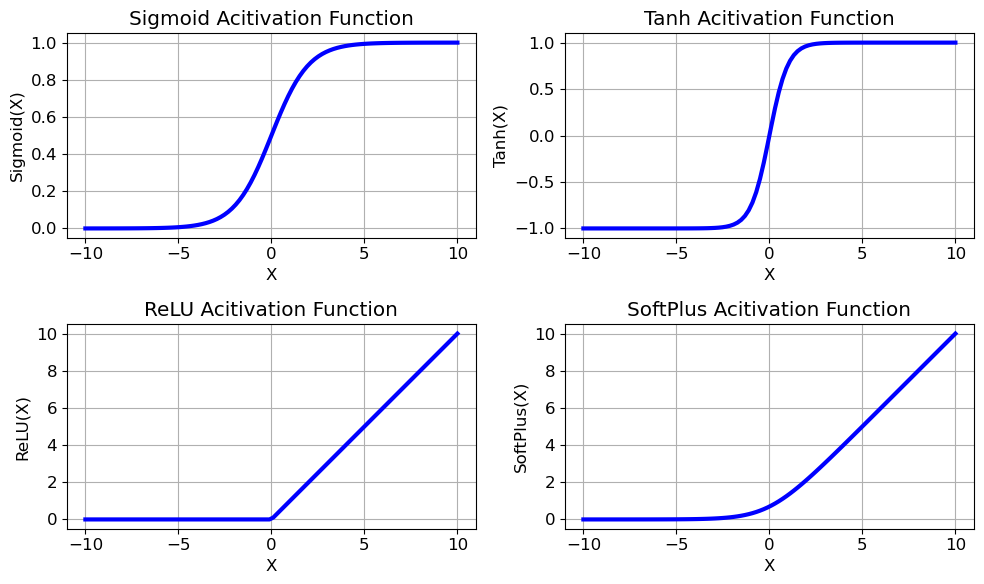

In [15]:
def activation_plot(func, name):
    X = np.linspace(-10, 10, 100)
    Xtv = Variable(torch.from_numpy(X).float())
    Y = func(Xtv).data.numpy()
    plt.plot(X, Y, 'b-', linewidth=3)
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('%s(X)' % (name))
    plt.title("%s Acitivation Function" % (name))


plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
activation_plot(torch.sigmoid, "Sigmoid")
plt.subplot(2, 2, 2)
activation_plot(torch.tanh, "Tanh")
plt.subplot(2, 2, 3)
activation_plot(torch.relu, "ReLU")
plt.subplot(2, 2, 4)
activation_plot(F.softplus, "SoftPlus")
plt.tight_layout()
plt.show()

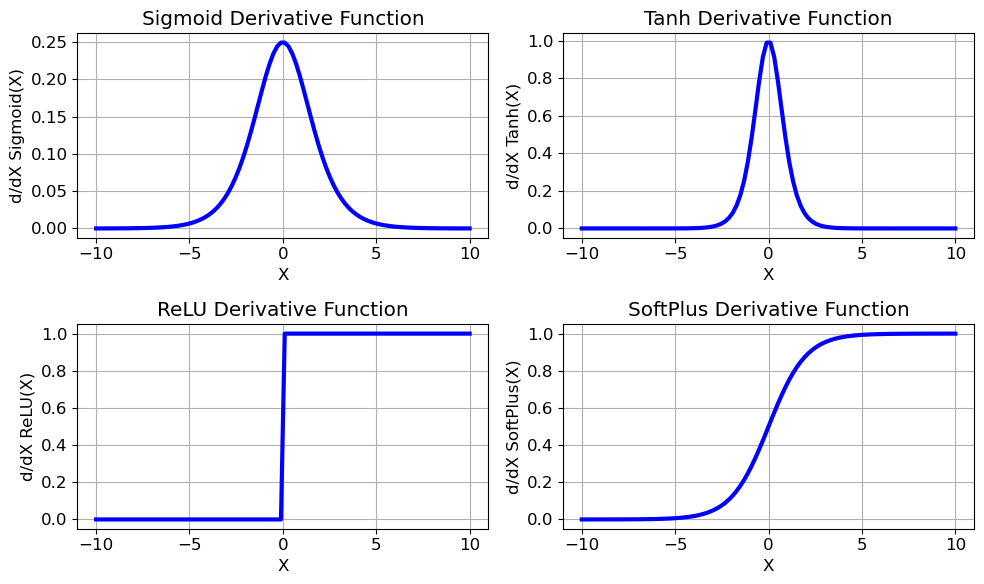

In [16]:
def activation_derivative_plot(func, name):
    X = np.linspace(-10, 10, 100)
    Xtv = Variable(torch.from_numpy(X).float(), requires_grad=True)
    Ytv = func(Xtv)
    Ytv.backward(torch.ones(X.size))
    dYdX = Xtv.grad.data.numpy()
    plt.plot(X, dYdX, 'b-', linewidth=3)
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('d/dX %s(X)' % (name))
    plt.title("%s Derivative Function" % (name))


plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
activation_derivative_plot(torch.sigmoid, "Sigmoid")
plt.subplot(2, 2, 2)
activation_derivative_plot(torch.tanh, "Tanh")
plt.subplot(2, 2, 3)
activation_derivative_plot(F.relu, "ReLU")
plt.subplot(2, 2, 4)
activation_derivative_plot(F.softplus, "SoftPlus")
plt.tight_layout()
plt.show()